# General Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

from pyCascade import probePost, physics, quantities
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy.optimize import curve_fit

category =  "config2"



In [2]:
############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)

'/scratch/users/nbachand/Cascade/city_block_cfd'

'/home/users/nbachand/Cascade/city_block_cfd'

# Run

In [3]:
run = 9
theta = 0;
qois = ['comp(u,0)', 'comp(u,2)']

In [4]:
probes = probePost.Probes(f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut', file_type = 'parquet')
probes.get_locations(f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut')

In [6]:
stack = [1, 6, 18, 42]

start = -80000
stop = -1
by = 1

## Spectra

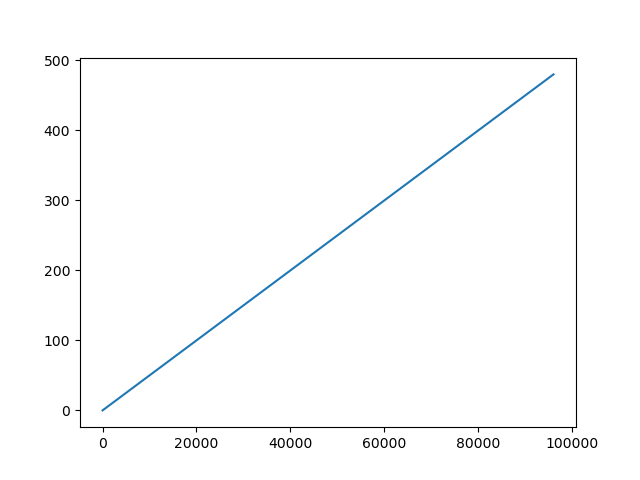

In [52]:
plt.figure()
plt.plot(probes.probe_steps, probes.probe_times)

processing data took 2 seconds
pressure data not founnd, replacing with zeros
processing data took 2 seconds
pressure data not founnd, replacing with zeros
processing data took 2 seconds
pressure data not founnd, replacing with zeros
processing data took 2 seconds
pressure data not founnd, replacing with zeros


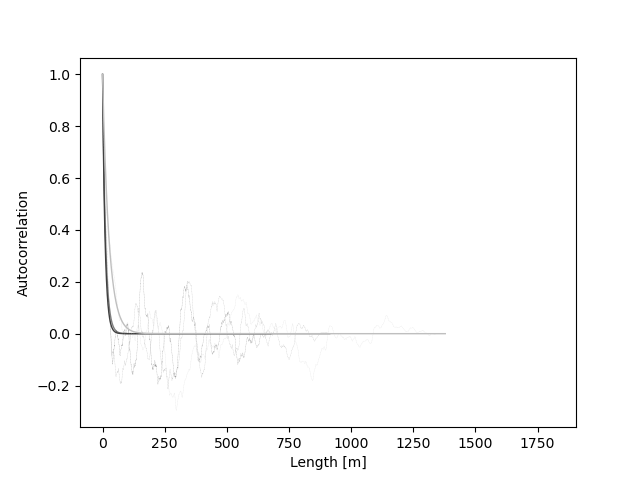

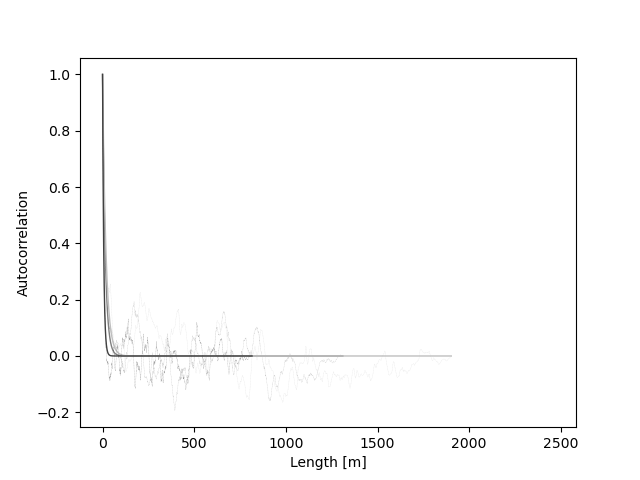

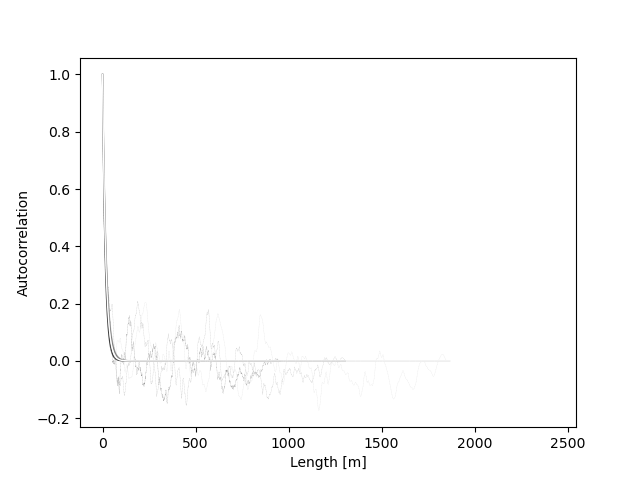

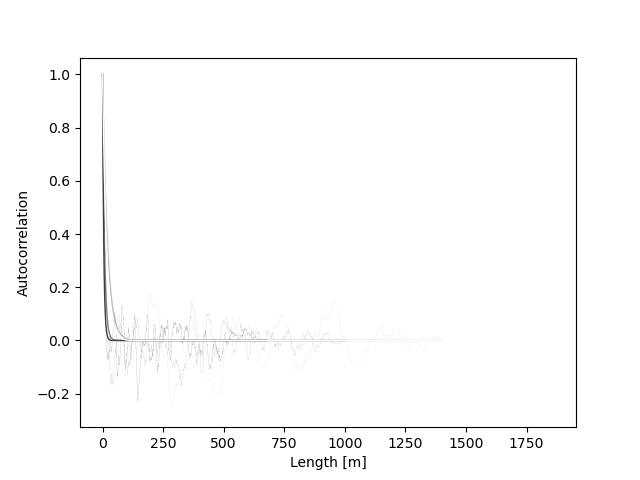

In [53]:
qty_dict = probes.create_qty_dict(
    theta_wind = theta,
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[start:stop:by],
    stack = stack
)


/home/users/nbachand/Cascade/city_block_cfd/pyCascade/quantities.py:299: RuntimeWarning: divide by zero encountered in power
  ylabel = f"${var}"


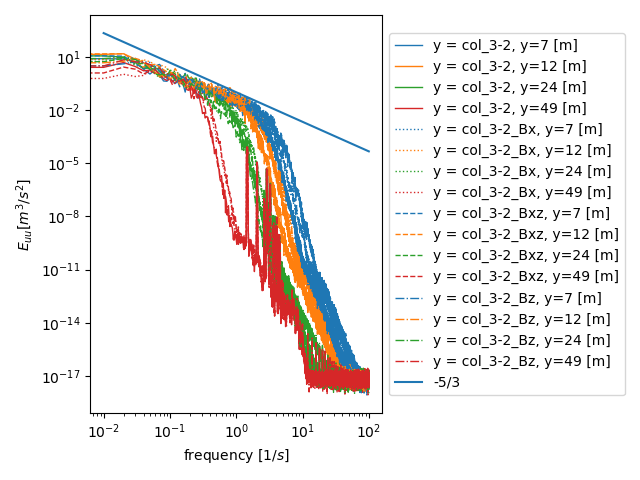

In [73]:
fig, ax = quantities.plot_power_spectra(qty_dict, var = 'Euu')

/home/users/nbachand/Cascade/city_block_cfd/pyCascade/quantities.py:276: RuntimeWarning: divide by zero encountered in reciprocal
  ylabel = f"${var}"


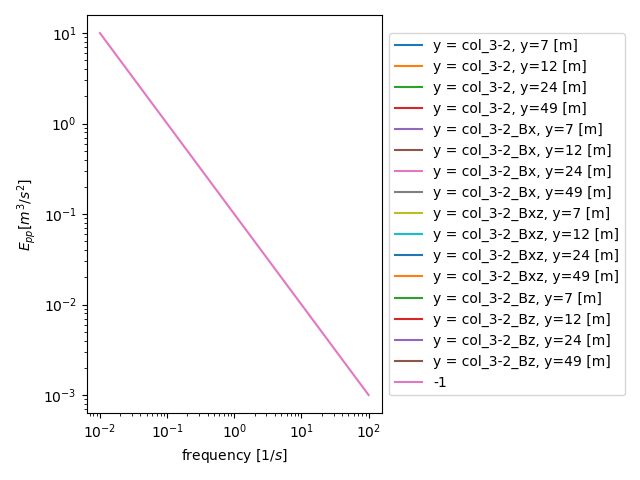

In [47]:
fig, ax = quantities.plot_power_spectra(qty_dict, var = "Epp", scaling = "-1")

## Plot ABL

processing data took 2 seconds
pressure data not founnd, replacing with zeros
processing data took 2 seconds
pressure data not founnd, replacing with zeros
processing data took 2 seconds
pressure data not founnd, replacing with zeros
processing data took 2 seconds
pressure data not founnd, replacing with zeros


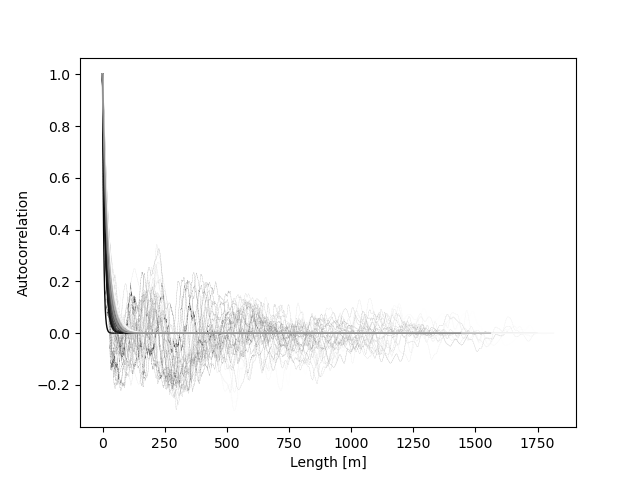

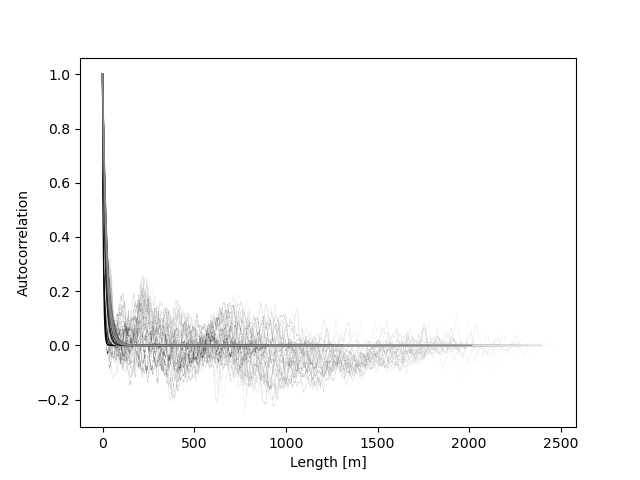

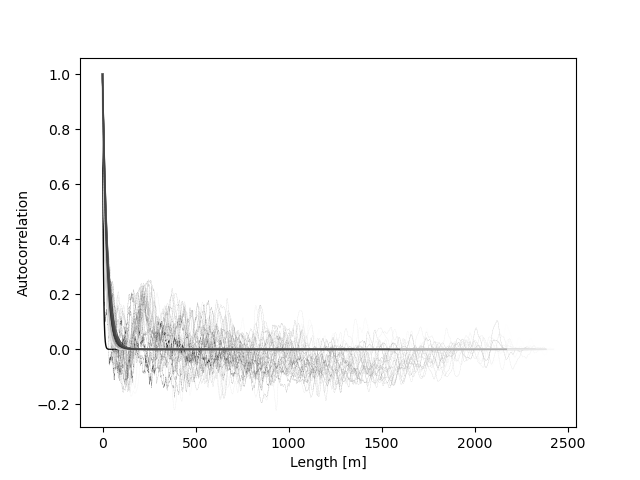

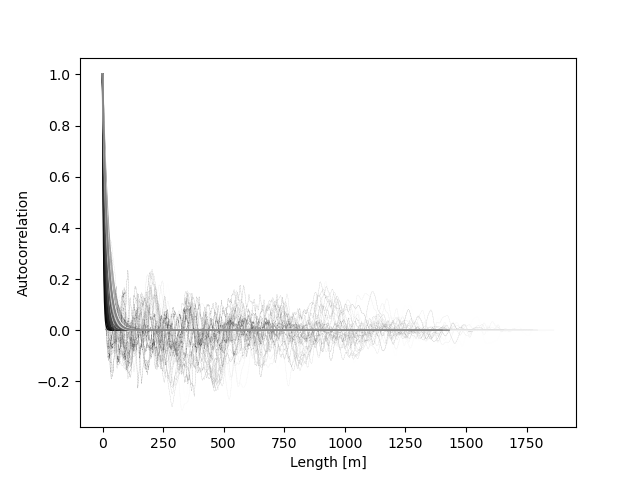

In [30]:
qty_dict = probes.create_qty_dict(
    theta_wind = theta,
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[start:stop:by],
    stack = np.arange(0,40)
)

col_3-2: u* = 0.6308827415910375, z0 = 2.5954053946388056, disp = 0.0
col_3-2_Bx: u* = 0.8561813634466745, z0 = 2.490516289781882, disp = 0.0
col_3-2_Bxz: u* = 0.8508600416511068, z0 = 2.479498565254144, disp = 0.0
col_3-2_Bz: u* = 0.5829236618597273, z0 = 2.0514464403898542, disp = 0.0


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='mean velocity [m/s]', ylabel='height [m]'>)

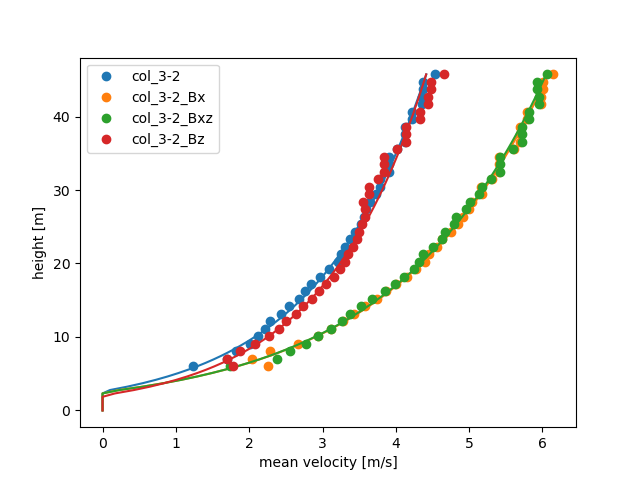

In [31]:
quantities.plot_ABL(qty_dict, fit_disp=True)

## Plot Length Scales

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: title={'center': 'Lx'}, xlabel='y [m]', ylabel='L [m]'>,
        <Axes: title={'center': 'Ly'}, xlabel='y [m]'>,
        <Axes: title={'center': 'Lz'}, xlabel='y [m]'>], dtype=object))

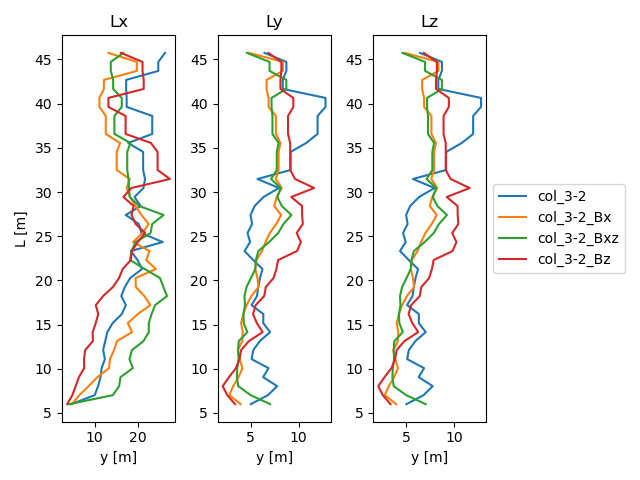

In [32]:
quantities.plot_length_scales(qty_dict)

## Plot Reynolds stresses

(<Figure size 640x480 with 6 Axes>,
 array([[<Axes: title={'center': 'uu'}, ylabel='y [m]'>,
         <Axes: title={'center': 'vv'}>, <Axes: title={'center': 'ww'}>],
        [<Axes: title={'center': 'uv'}, ylabel='y [m]'>,
         <Axes: title={'center': 'uw'}, xlabel='Reynolds Stress [m^2/s^2]'>,
         <Axes: title={'center': 'vw'}>]], dtype=object))

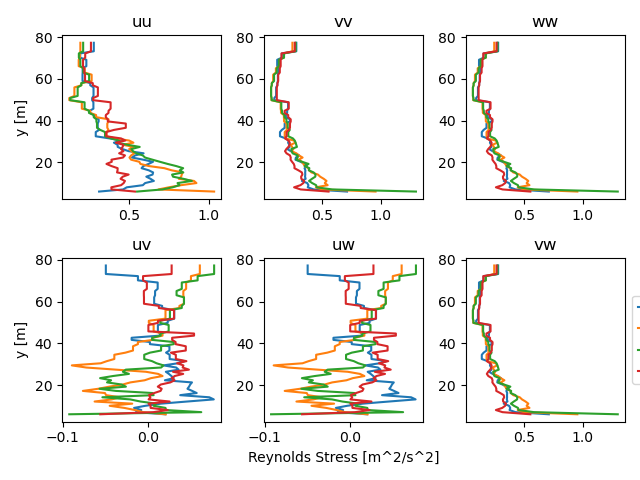

In [12]:
quantities.plot_reynolds_stresses(qty_dict)

## Plot Turbulence Intensities

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: xlabel='Iu', ylabel='y [m]'>, <Axes: xlabel='Iv'>,
        <Axes: xlabel='Iw'>], dtype=object))

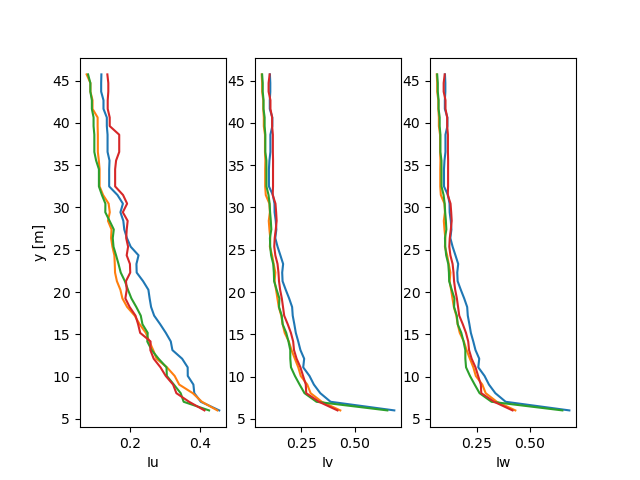

In [33]:
quantities.plot_turbulence_intensities(qty_dict)

## Plot prms

In [ ]:
quantities.plot_prms(qty_dict)